# Chronos-2 Foundation Model Fine-Tuning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()
%matplotlib inline

In [3]:
import warnings

import numpy as np

from darts.datasets import AirPassengersDataset
from darts.models import Chronos2Model

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

## Data Preparation

In [4]:
# convert to float32 as Chronos-2 works with float32 input
data = AirPassengersDataset().load().astype(np.float32)
train_passengers, val_passengers = data.split_before(
    len(data) - 2 * 12
)  # last 2 years for validation

# Model prediction out-of-the-box
Let's see how the model behaves on the validation data without any fine-tuning. For that we:
- Create the model
- Call fit to load the model internally (no training is done)
- Predict on the validation set

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

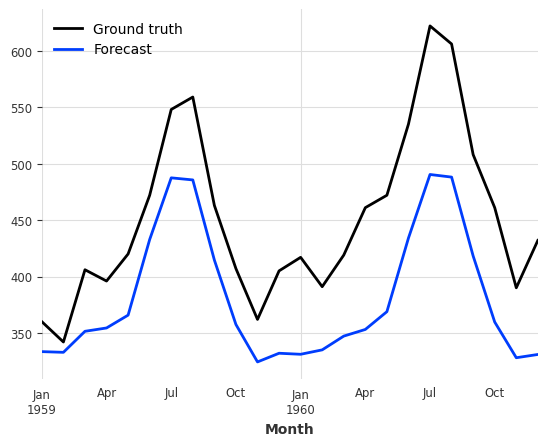

In [13]:
model = Chronos2Model(
    input_chunk_length=24,
    output_chunk_length=6,
)
model.fit(train_passengers, verbose=True)

prediction = model.predict(
    n=len(val_passengers),
    series=train_passengers,
)
val_passengers.plot(label="Ground truth")
prediction.plot(label="Forecast")

# Full fine-tuning

In this method, all the model weights are retrained. This is done with `enable_finetuning=True` in the model constructor.

The model is saved then loaded to show that Darts model saving and restoration continue to work with the different fine-tuning methods

In [7]:
model = Chronos2Model(
    input_chunk_length=24,
    output_chunk_length=6,
    enable_finetuning=True,
    n_epochs=100,
    pl_trainer_kwargs={"accelerator": "gpu"},
)
model.fit(train_passengers, verbose=True)
model.save("full_finetuned.pt")

# Load
loaded = Chronos2Model.load("full_finetuned.pt")

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

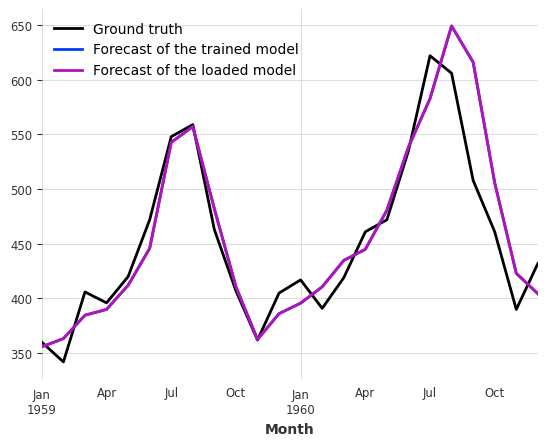

In [8]:
pred_trained = model.predict(
    n=len(val_passengers),
    series=train_passengers,
)
pred_loaded = loaded.predict(
    n=len(val_passengers),
    series=train_passengers,
)
val_passengers.plot(label="Ground truth")
pred_trained.plot(label="Forecast of the trained model")
pred_loaded.plot(label="Forecast of the loaded model")

We can also verify that the prediction of the trained model is identical to the prediction of the loaded model

In [22]:
pred_trained == pred_loaded

False

# Partial fine-tuning with layer freezing

In [29]:
from darts.models.forecasting.foundation_model import LayerFreezeCallback

freeze_callback = LayerFreezeCallback(
    freeze_patterns=["encoder.block.0", "encoder.block.1", "encoder.block.2"],
    unfreeze_patterns=["output_patch_embedding"],
)

model = Chronos2Model(
    input_chunk_length=12,
    output_chunk_length=6,
    enable_finetuning=True,
    n_epochs=100,
    pl_trainer_kwargs={"accelerator": "gpu", "callbacks": [freeze_callback]},
)
model.fit(train_passengers, verbose=True)
model.save("partial_finetuned.pt")

# Load - no callback needed, structure unchanged
loaded = Chronos2Model.load("partial_finetuned.pt")

Model transformed. Trainable: 72,280,224/119,477,664 (60.50%)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

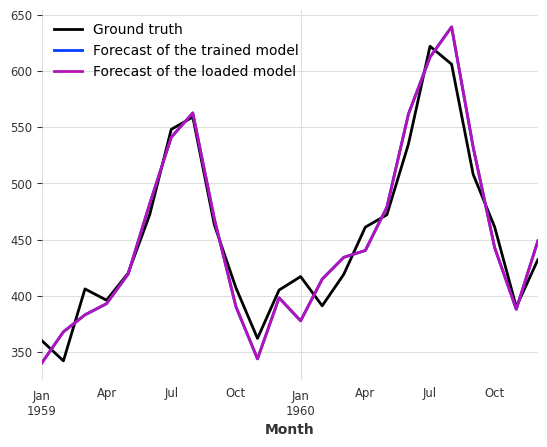

In [30]:
pred_trained = model.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
pred_loaded = loaded.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
val_passengers.plot(label="Ground truth")
pred_trained.plot(label="Forecast of the trained model")
pred_loaded.plot(label="Forecast of the loaded model")

Again, we verify that the prediction of the fine-tuned model is the same as the loaded model to make sure that saving/load works correctly

In [31]:
pred_trained == pred_loaded

True

# LoRA fine-tuning

In [ ]:
from peft import LoraConfig

from darts.models.forecasting.foundation_model import PeftCallback

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q",
        "v",
        "k",
        "o",
        "output_patch_embedding.output_layer",
    ],
    # lora_dropout=0.1,
)
peft_callback = PeftCallback(peft_config=lora_config)

model_lora = Chronos2Model(
    input_chunk_length=24,
    output_chunk_length=6,
    enable_finetuning=True,
    n_epochs=100,
    pl_trainer_kwargs={"accelerator": "gpu", "callbacks": [peft_callback]},
    log_tensorboard=True,
)
model_lora.fit(train_passengers, verbose=True)

# Fully save the model including adapters
model_lora.save("chronos2_lora_finetuned.pt")
loaded = Chronos2Model.load("chronos2_lora_finetuned.pt")
# loaded_full = Chronos2Model.load("chronos2_lora_finetuned.pt")

# # Save adapters using PEFT's native method
# model.model.model.save_pretrained("chronos2_lora_adapters/")

# # # === Loading ===
# model = Chronos2Model(
#     input_chunk_length=12,
#     output_chunk_length=6,
#     enable_finetuning=True,
#     n_epochs=10,
#     pl_trainer_kwargs={"callbacks": [peft_callback]},
# )
# model.fit(train_passengers, verbose=True)
# model.model.model.load_adapter("chronos2_lora_adapters/")

Model transformed. Trainable: 1,206,912/120,684,576 (1.00%)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

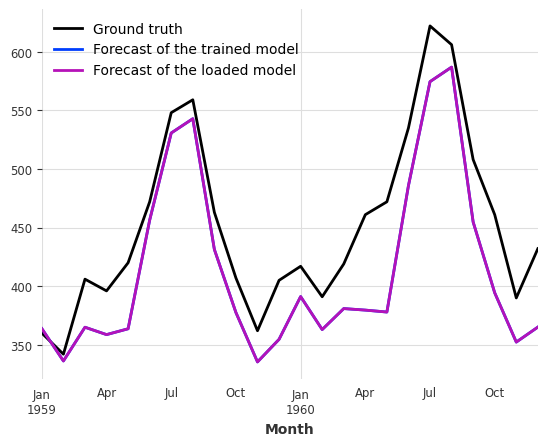

In [6]:
pred_trained = model_lora.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
pred_loaded = loaded.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
val_passengers.plot(label="Ground truth")
pred_trained.plot(label="Forecast of the trained model")
pred_loaded.plot(label="Forecast of the loaded model")

In [8]:
np.allclose(pred_trained.values(), pred_loaded.values())

True

In [106]:
import torch

model_without_lora = model_lora.model.model.merge_and_unload()

assert len(loaded.model.state_dict().keys()) == len(
    model_without_lora.state_dict().keys()
)

for key_loaded, key_lora in zip(
    loaded.model.state_dict().keys(), model_without_lora.state_dict().keys()
):
    assert torch.equal(
        loaded.model.state_dict()[key_loaded], model_without_lora.state_dict()[key_lora]
    )